In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import my_utils as myf

In [2]:
mydir = './data/sia_sie_siv_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'nh' in f]

In [3]:
listds = []
for f in myfiles:
    if 'OB' not in f:
        ds = xr.open_dataset(f)[['sie_nh']]
        ds = ds.set_coords('names')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [4]:
mydir = './data/sia_sie_siv_timeseries/cdrv4_orig_grid/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'nh' in f]
listds = []
for f in myfiles:
        obds = xr.open_dataset(f)
        obds = obds.set_coords('names')
        obds['time'] = ds.time.values
        listds.append(obds)
obds = xr.concat(listds,dim='names')[['sie_nh']]

In [5]:
ds = xr.concat([obds, ds], dim='names')

In [6]:
ds = myf.xr_reshape(ds.sie_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)]).to_dataset(name='sie_nh')

In [7]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [8]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [9]:
ds = xr.concat([ds,lensmean, a60nudgemean],dim='names')

In [10]:
lineplotprop = myf.set_line_prop(ds.names.values)

In [11]:
slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year, ds.load(), dim='year')
detrended = ds - slope*ds.year
annmean = ds.mean(dim='month')
annmean_slope, _, _, annmean_p_value, _ = myf.linregress(ds.year, annmean.load(), dim='year')
annmean_detrended = annmean - annmean_slope*ds.year

In [12]:
mydata_lensmean = 10.*slope.sel(names='LENSmean').sie_nh.sel(month=9).values
for n, name in enumerate(ds.names.values):
    if ('nudge' in name and '60' in name) or 'aNUDGEm' in name or 'OB' in name:
        mydata = 10.*slope.sel(names=name).sie_nh.sel(month=9).values
        print('Sep SIE trend in LENS mean divided by '+name+' ----- {:.0f} %'.format(100.*mydata_lensmean/mydata))

Sep SIE trend in LENS mean divided by OBS-CDRv4-bt ----- 71 %
Sep SIE trend in LENS mean divided by OBS-CDRv4-cdr ----- 73 %
Sep SIE trend in LENS mean divided by OBS-CDRv4-nt ----- 72 %
Sep SIE trend in LENS mean divided by anom_nudge_era_60 ----- 75 %
Sep SIE trend in LENS mean divided by anom_nudge_era_60_archi ----- 80 %
Sep SIE trend in LENS mean divided by anom_nudge_era_60_arclo ----- 78 %
Sep SIE trend in LENS mean divided by aNUDGEmean ----- 78 %


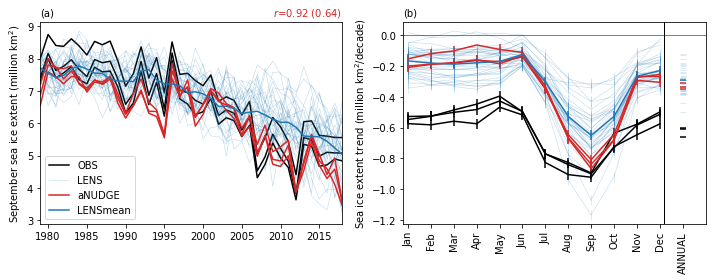

In [13]:
fig = plt.figure(figsize=(10,4))
hemi = 'sie_nh'
mon = 9
ax = plt.subplot(1,2,1)
for n, name in enumerate(ds.names.values):
        if 'LENS' in name or '60' in name or 'OBS' in name:
            ds.sel(names=name)[hemi].sel(month = mon).plot(ax = ax, **lineplotprop[name].to_dict())     

pearson3, _ = myf.pearson(ds.sel(names='OBS-CDRv4-cdr')[hemi].sel(month = mon).load(), ds.sel(names='aNUDGEmean')[hemi].sel(month = mon).load(),dim='year')
pearson3detrended, _ = myf.pearson(detrended.sel(names='OBS-CDRv4-cdr')[hemi].sel(month = mon).load(), detrended.sel(names='aNUDGEmean')[hemi].sel(month = mon).load(),dim='year')

ax.set_title('')
ax.set_title('$r$={:0.2f} ({:1.2f})'.format(pearson3.values,pearson3detrended.values),fontsize=10, loc='right', c='tab:red')
ax.set_title('(a)', fontsize=10, loc='left')
ax.set_xlim([1979,2018])
ax.set_ylabel('September sea ice extent (million km$^2$)')
ax.set_xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax = plt.subplot(1,2,2)
for n, name in enumerate(ds.names.values):
    if 'LENS' in name or '60' in name or 'OBS' in name:
        

        (10.*slope).sel(names=name)[hemi].plot(ax = ax, **lineplotprop[name].to_dict())
        

        for m in range(12):
            if p_value.sel(names=name)[hemi].values[m]<.05:
                ax.scatter(m+1,(10.*slope).sel(names=name)[hemi].values[m], **lineplotprop[name].to_dict(), marker='|',s=100)

        ax.scatter(13,10.*annmean_slope.sie_nh.sel(names=name),**lineplotprop[name].to_dict(), marker='_')
ax.set_title('')
ax.set_title('(b)', fontsize=10, loc='left')
ax.set_xlim([1,14])
ax.set_xticks(np.arange(1,14,1))
ax.set_xticklabels(myf.monthnames+['ANNUAL'], rotation='vertical')
ax.set_xlabel('')
ax.set_ylabel('Sea ice extent trend (million km$^2$/decade)')
ax.set_xlabel('')
ax.axhline(y=0., c='k', linewidth = 0.5)
ax.axvline(x=12.2,c='k',linewidth=1)
ax.set_xlim([.8,14])
plt.tight_layout()
fig.savefig('figs/sie.pdf',dpi=500, bbox_inches='tight')
plt.show(); plt.close()

## Now plot SIV

In [14]:
mydir = './data/sia_sie_siv_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if '.nc' in f]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

In [15]:
# read in PIOMAS
import csv
import pandas as pd
names=[ 'Year',1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
df = pd.read_csv('./data/piomas_v2.1_cp20210119.csv',names=names)
df = df.set_index(['Year'])
da = df.to_xarray()

In [16]:
listds = []
for f in myfiles:
    if 'OB' not in f:
        sivds = xr.open_dataset(f)[['siv_nh']]
        sivds = sivds.set_coords('names')
        listds.append(sivds)
sivds = xr.concat(listds,dim='names')
sivds = myf.xr_reshape(sivds.siv_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)]).to_dataset(name='siv_nh')

In [17]:
thelens = [f for f in sivds.names.values if 'LENS' in f]
lensmean = sivds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')
sivds = xr.concat([sivds,lensmean],dim='names')

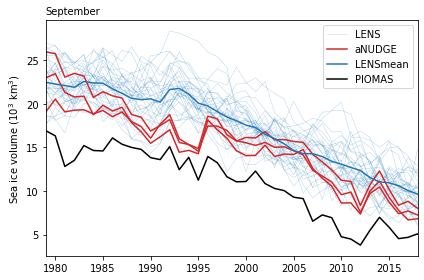

In [18]:
fig = plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)

for n, name in enumerate(sivds.names.values):
    if 'LENS' in name or '60' in name:
        sivds.sel(names=name).siv_nh.sel(month = 9).plot(ax = ax, **lineplotprop[name].to_dict())     

p4, = ax.plot(np.arange(1979,2021,1),da[9],c='k',label='PIOMAS')

ax.set_title('')
ax.set_title('September',loc='left',fontsize=10)
ax.set_xlim([1979,2018])
ax.set_ylabel('Sea ice volume (10$^3$ km$^3$)')
ax.set_xlabel('')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
fig.savefig('figs/siv.pdf',dpi=500, bbox_inches='tight')
plt.show(); plt.close()

In [19]:
initial_states = sivds.isel(month=0).isel(year=0).sel(names=[f for f in sivds.names.values if '60' in f]).siv_nh.values

In [20]:
print('Initial Arctic SIV states span {:.2f} 10^3 km^3'.format(max(initial_states)-min(initial_states)))

Initial Arctic SIV states span 8.28 10^3 km^3


In [21]:
mydict={}
for name in ['OBS-CDRv4-cdr','LENSmean','aNUDGEmean']:
    mylist = []
    for period in [[0,None],[0,20],[20,None]]:  
        trend, intercept, r_value, p_value, std_err =myf.linregress(ds.isel(year=slice(period[0],period[1])).year, 
                                                                    ds.isel(year=slice(period[0],period[1])).sel(names=name).sie_nh.sel(month=9).load(), dim='year')
        
        entry = '{:.2f} $\pm$ {:.2f} million km$^2$ /decade p={:.0f} \%'.format(10.*trend.values,10.*std_err.values,100.*p_value.values)
        
        mylist.append(entry)
    mydict[name] = mylist

        

In [22]:
print('Sea ice extent trends over 1979-2018,1979-1998, 1999-2018')
pd.DataFrame(mydict).transpose()

Sea ice extent trends over 1979-2018,1979-1998, 1999-2018


,0,1,2
OBS-CDRv4-cdr,-0.89 $\pm$ 0.08 million km$^2$ /decade p=0 \%,-0.42 $\pm$ 0.18 million km$^2$ /decade p=3 \%,-1.02 $\pm$ 0.22 million km$^2$ /decade p=0 \%
LENSmean,-0.65 $\pm$ 0.03 million km$^2$ /decade p=0 \%,-0.26 $\pm$ 0.06 million km$^2$ /decade p=0 \%,-0.91 $\pm$ 0.04 million km$^2$ /decade p=0 \%
aNUDGEmean,-0.84 $\pm$ 0.08 million km$^2$ /decade p=0 \%,-0.46 $\pm$ 0.19 million km$^2$ /decade p=3 \%,-1.43 $\pm$ 0.19 million km$^2$ /decade p=0 \%
